---

# InClass Kaggle Competition - Example - Python - v5.3

This notebook gives an example on the implementation of machine learning pipeline for the InClass Kaggle Competition.

Last update on: 22/03/2022

---

The machine learning pipeline includes:

1. Data processing (Part 2)
- [x] Error correction
- [x] Feature engineering
- [x] Value transformation
- [x] Value representation
- [x] Variable selection

2. Modeling (Part 3)
- [x] Logistic Regression, Random Forest, XGBoost
- [x] Hyper parameter tuning

3. Experimental setup (Part 3)
- [x] k-fold CV
- [x] Oversampling [DROPPED]

4. Debuging (Part 3)
- [x] Analyzing k-fold CV
- [x] Learning curve

In [500]:
%%time
# Version
exp_version = 'v5.3'  # Experiment version
data_prep = 'full'  # full = data transformation, representation, std = standard, only dummy encode
var_set = 'fs'  # all = all vars, fs = top fisher score, pca = first PCs
fname = '_' + data_prep + '_' + var_set + '_' + exp_version  # Name of output file
print(fname)

_full_fs_v5.3
CPU times: total: 0 ns
Wall time: 0 ns


In [501]:
%%time
###################################################################
# MODIFY THESE FLAGS TO TURN ON/OFF THE DATA PROCESSING FUNCTIONS #
###################################################################

# Flag variables to run the data processing steps
# Feature engineering step
enable_num_poly = True  # Add polynomial terms
# Value transformation step
enable_trans_cat_dt = False  # Remapping cat variables - Decision tree–based remapping
enable_trans_num_dt = False  # Discretizing num variables - Decision tree–based discretization
enable_trans_num_ef = True  # Discretizing num variables - Equal frequency discretization
enable_trans_num_ew = False  # Discretizing num variables - Equal width discretization
# Value representation step
enable_repr_dummy = True  # Represent cat variables - Dummy coding
enable_repr_icd = False  # Represent cat variables - Incidence (of target variable) replacement
enable_repr_woe = True  # Represent cat variables - Weight-of-Evidence (WoE) conversion
drop_cat_vars = True  # Drop cat variables after value representation step
# Other data processing
enable_normalize = True  # Normalize the data to the same range [0, 1]

CPU times: total: 0 ns
Wall time: 0 ns


## Initiation

In [502]:
%%time
# Data exploration
import matplotlib.pyplot as plt

# Data processing
import pickle
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, KBinsDiscretizer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import mutual_info_classif, VarianceThreshold
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA

# Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier,VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier

# Experimental setup
from sklearn.model_selection import KFold, StratifiedKFold, cross_validate, GridSearchCV
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import learning_curve

CPU times: total: 0 ns
Wall time: 0 ns


## 1. Data summary

#### (a) Read and print out some data

In [503]:
%%time
# Read train, test
train = pd.read_csv('./data/processed/g2/credit_default_train.csv', low_memory=False)
test = pd.read_csv('./data/processed/g2/credit_default_test.csv', low_memory=False)

CPU times: total: 93.8 ms
Wall time: 93 ms


In [504]:
%%time
# Print out to check the data
print(train.dtypes.value_counts())
train.head()

float64    23
int64       2
dtype: int64
CPU times: total: 0 ns
Wall time: 2.49 ms


cust_id  LIMIT_BAL  SEX  EDUCATION  MARRIAGE   AGE  PAY_0  PAY_2  PAY_3  \
0    18895    70000.0  1.0        3.0       2.0  34.0    0.0    0.0    0.0   
1    25102   390000.0  2.0        2.0       2.0  26.0    2.0    2.0    2.0   
2    28867    60000.0  1.0        1.0       2.0  27.0    0.0    0.0    0.0   
3     1842   140000.0  2.0        2.0       1.0  55.0    0.0    0.0    0.0   
4     3371    50000.0  1.0        1.0       2.0  29.0    2.0    2.0    2.0   

   PAY_4  ...  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  \
0    0.0  ...    25559.0    26134.0    26715.0    1700.0    1500.0    2000.0   
1    0.0  ...   140387.0   128112.0   115514.0    5000.0    3000.0    5000.0   
2    0.0  ...    26038.0    28607.0    27997.0    1378.0    1406.0    3000.0   
3    0.0  ...    72391.0    61298.0    62193.0    4200.0    2822.0    2336.0   
4    0.0  ...     1047.0        0.0        0.0    3000.0       0.0    1000.0   

   PAY_AMT4  PAY_AMT5  PAY_AMT6  default.payment.next.month  
0    1000.0    1000.0    2000.0                           0  
1    4548.0    4100.0    3300.0                           0  
2    3000.0       0.0     923.0                           1  
3    2588.0    2250.0    2491.0                           0  
4       0.0       0.0       0.0                           1  

[5 rows x 25 columns]

#### (b) Create a list of column names to manage variables

In [505]:
%%time
# General list of variables
id_var = ["cust_id"]  # ID
target_var = ["default.payment.next.month"]  # Target get variable
predictors = [v for v in train.columns if v not in id_var + target_var]

# List of numerical and catergorical variables
num_vars = ['LIMIT_BAL', 'AGE',
            'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
            'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
cat_vars = ['SEX', 'EDUCATION', 'MARRIAGE',
            'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

# Double check the list of variables
assert(len(predictors) == len(num_vars) + len(cat_vars))

CPU times: total: 0 ns
Wall time: 0 ns


#### (c) Check the target variable class distribution

In [506]:
%%time
# By number
print(train[target_var].value_counts())

# By percentage
print(train[target_var].value_counts(normalize=True))

default.payment.next.month
0                             15586
1                              4414
dtype: int64
default.payment.next.month
0                             0.7793
1                             0.2207
dtype: float64
CPU times: total: 0 ns
Wall time: 8 ms


## 2. Processing data

### 2.1. Error, data correction

#### (a) Check and correct data error - Constant variables

Constant variables on train do not contain information and may cause data processing or model training error.

In [507]:
%%time
# Count number of unique values of each variable
vars_nunique = train[num_vars + cat_vars].apply(pd.Series.nunique, dropna=False, axis=0)
cont_vars = vars_nunique.index[vars_nunique < 2].tolist()
print("Drop constant variable:", cont_vars)

# Correct variable list
num_vars = [v for v in num_vars if v not in cont_vars]
cat_vars = [v for v in cat_vars if v not in cont_vars]

# Update train, test
train = train[id_var + num_vars + cat_vars + target_var]
test = test[id_var + num_vars + cat_vars]

Drop constant variable: []
CPU times: total: 31.2 ms
Wall time: 28 ms


#### (b) Check and correct data error - Missing values

<u>Note:</u>
- Always create indicators (dummy variable) to track the missing values imputation.
- Since we already filtered out the constant NA vars, the imputor will not drop any vars.

In [508]:
%%time
# Check missing value
print('Train - # NA of num vars:', train[num_vars].isna().sum().sum())
print('Train - # NA of cat vars:', train[cat_vars].isna().sum().sum())
print('Test - # NA of num vars:', test[num_vars].isna().sum().sum())
print('Test - # NA of cat vars:', test[cat_vars].isna().sum().sum())

Train - # NA of num vars: 2700
Train - # NA of cat vars: 1748
Test - # NA of num vars: 1443
Test - # NA of cat vars: 916
CPU times: total: 15.6 ms
Wall time: 13 ms


In [509]:
%%time
# Here, we test the effect of dropping variables with high missing percentage (>30%)
na_threshold = 0.3

# Drop num variables with more than 30% missing values
num_na_pct = train[num_vars].isnull().mean()
num_vars = num_na_pct[num_na_pct <= na_threshold].index.tolist()
print("Drop num variables with high missing pct:", num_na_pct[num_na_pct > na_threshold].tolist())

# Drop cat variables with more than 30% missing values
cat_na_pct = train[cat_vars].isnull().mean()
cat_vars = cat_na_pct[cat_na_pct <= 0.3].index.tolist()
print("Drop cat variables with high missing pct:", cat_na_pct[cat_na_pct > na_threshold].tolist())

# Update train, test
train = train[id_var + num_vars + cat_vars + target_var]
test = test[id_var + num_vars + cat_vars]

Drop num variables with high missing pct: []
Drop cat variables with high missing pct: []
CPU times: total: 15.6 ms
Wall time: 16.3 ms


In [510]:
%%time
# List dummary variables to track missing values imputation
na_vars = []

CPU times: total: 0 ns
Wall time: 0 ns


In [511]:
%%time
# Numerical variables
# Build the missing value imputor using the mean
imp = SimpleImputer(missing_values=np.nan, strategy='mean', add_indicator=True)
imp.fit(train[num_vars])

# Reconstruct the list of vars + indicators
na_vars = na_vars + [num_vars[v] + "_na" for v in imp.indicator_.features_]
impute_vars = num_vars + na_vars

# Apply on train, test
train[impute_vars] = pd.DataFrame(imp.transform(train[num_vars]), columns=impute_vars)
test[impute_vars] = pd.DataFrame(imp.transform(test[num_vars]), columns=impute_vars)

CPU times: total: 62.5 ms
Wall time: 51 ms


In [512]:
%%time
# Categorical variables
# Impute missing value using a new category "Missing"
# Note: If the categorical vars are imputed by most_frequent, the indicators should be added
train[cat_vars] = train[cat_vars].fillna('Missing')
test[cat_vars] = test[cat_vars].fillna('Missing')

CPU times: total: 188 ms
Wall time: 186 ms


#### (c) Check and correct data error - Outliers in numerical variables

Here, we only check but not impute the outliers.

<u>Note:</u>
- Before correcting outliers, make sure to understand the nature of the error.
- Do not need to correct outliers for missing values indicators.

In [513]:
%%time
# Check the outliers on train, test
for v in num_vars:
    # Calculate the boundaries on train [mean-3*sd, mean+3*sd]
    mu = np.mean(train[v])
    sd = np.std(train[v])
    lower = mu - 3*sd
    upper = mu + 3*sd
    # Check outliers using the boundaries
    train_out = (train[v] < lower) | (train[v] > upper)
    test_out = (test[v] < lower) | (test[v] > upper)
    if np.sum(train_out) + np.sum(test_out) > 0:
        print(v, "has # outliers on train, test :",
              np.sum(train_out), "[", np.round(100*np.mean(train_out), 2), "% ]",
              np.sum(test_out), "[", np.round(100*np.mean(test_out), 2), "% ]")

LIMIT_BAL has # outliers on train, test : 92 [ 0.46 % ] 37 [ 0.37 % ]
AGE has # outliers on train, test : 89 [ 0.44 % ] 51 [ 0.51 % ]
BILL_AMT1 has # outliers on train, test : 458 [ 2.29 % ] 225 [ 2.25 % ]
BILL_AMT2 has # outliers on train, test : 457 [ 2.28 % ] 208 [ 2.08 % ]
BILL_AMT3 has # outliers on train, test : 439 [ 2.2 % ] 220 [ 2.2 % ]
BILL_AMT4 has # outliers on train, test : 454 [ 2.27 % ] 228 [ 2.28 % ]
BILL_AMT5 has # outliers on train, test : 434 [ 2.17 % ] 216 [ 2.16 % ]
BILL_AMT6 has # outliers on train, test : 437 [ 2.18 % ] 212 [ 2.12 % ]
PAY_AMT1 has # outliers on train, test : 284 [ 1.42 % ] 159 [ 1.59 % ]
PAY_AMT2 has # outliers on train, test : 199 [ 1.0 % ] 118 [ 1.18 % ]
PAY_AMT3 has # outliers on train, test : 253 [ 1.26 % ] 111 [ 1.11 % ]
PAY_AMT4 has # outliers on train, test : 266 [ 1.33 % ] 133 [ 1.33 % ]
PAY_AMT5 has # outliers on train, test : 278 [ 1.39 % ] 132 [ 1.32 % ]
PAY_AMT6 has # outliers on train, test : 302 [ 1.51 % ] 131 [ 1.31 % ]
CPU times: 

In [514]:
#Grouping categorical variables
#train
train.loc[train['EDUCATION'].isin([0.0,5.0,6.0,'Missing']),'EDUCATION'] = 'Missing'
train.loc[train['MARRIAGE'].isin([0.0]),'MARRIAGE'] = 'Missing'
train.loc[train['PAY_0'].isin([5.0,6.0,7.0,8.0,9.0]),'PAY_0'] = ">=5"
train.loc[train['PAY_2'].isin([5.0,6.0,7.0,8.0,9.0]),'PAY_2'] = ">=5"
train.loc[train['PAY_3'].isin([5.0,6.0,7.0,8.0,9.0]),'PAY_3'] = ">=5"
train.loc[train['PAY_4'].isin([5.0,6.0,7.0,8.0,9.0]),'PAY_4'] = ">=5"
train.loc[train['PAY_5'].isin([5.0,6.0,7.0,8.0,9.0]),'PAY_5'] = ">=5"
train.loc[train['PAY_6'].isin([5.0,6.0,7.0,8.0,9.0]),'PAY_6'] = ">=5"
#test
test.loc[test['EDUCATION'].isin([0.0,5.0,6.0,'Missing']),'EDUCATION'] = 'Missing'
test.loc[test['MARRIAGE'].isin([0.0]),'MARRIAGE'] = 'Missing'
test.loc[test['PAY_0'].isin([5.0,6.0,7.0,8.0,9.0]),'PAY_0'] = ">=5"
test.loc[test['PAY_2'].isin([5.0,6.0,7.0,8.0,9.0]),'PAY_2'] = ">=5"
test.loc[test['PAY_3'].isin([5.0,6.0,7.0,8.0,9.0]),'PAY_3'] = ">=5"
test.loc[test['PAY_4'].isin([5.0,6.0,7.0,8.0,9.0]),'PAY_4'] = ">=5"
test.loc[test['PAY_5'].isin([5.0,6.0,7.0,8.0,9.0]),'PAY_5'] = ">=5"
test.loc[test['PAY_6'].isin([5.0,6.0,7.0,8.0,9.0]),'PAY_6'] = ">=5"

#### (d) Encode categorical variables

In Python, most of the machine learning libraries will not handle non-numerical values of categorical varibales (e.g. RF). Therefore, we should encoded the categories using integer values.

<u>Note:</u>
- Here, the encoder is fitted on both train and test. Therefore, in a few special cases, there are unique categories that appear only on train, or test.

In [515]:
%%time
# Encode categorical variables as integer values
# Categorical variables in any format will be converted to string
# Note: All the NA values were imputed previously
enc = OrdinalEncoder()
enc.fit(pd.concat([train[cat_vars].astype(str), test[cat_vars].astype(str)], axis=0))
# Apply on train, test
train[cat_vars] = enc.transform(train[cat_vars].astype(str))
test[cat_vars] = enc.transform(test[cat_vars].astype(str))

CPU times: total: 469 ms
Wall time: 438 ms


#### (e) Finalize the processed data

Current lists of variables:
- id_var : customer ID
- num_vars : numerical variables
- cat_vars : categorical variables
- na_vars : indicators for tracking missing values, bool [False, True]
- target_var : target variable, churn [0, 1]

<u>Note:</u> If there are any variables exist in only train or test, drop them from all the data.

In [516]:
%%time
# Convert bool variable to int
train[na_vars] = train[na_vars].astype(np.int8)
test[na_vars] = test[na_vars].astype(np.int8)

CPU times: total: 78.1 ms
Wall time: 71.2 ms


In [517]:
%%time
# Print out the final variables
print("# id_var [", len(id_var), "] :", id_var)
print("# num_vars [", len(num_vars), "] :", num_vars[:5], "...")
print("# cat_vars [", len(cat_vars), "] :", cat_vars[:5], "...")
print("# na_vars [", len(na_vars), "] :", na_vars[:5], "...")
print("# target_var [", len(target_var), "] :", target_var)

# id_var [ 1 ] : ['cust_id']
# num_vars [ 14 ] : ['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3'] ...
# cat_vars [ 9 ] : ['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2'] ...
# na_vars [ 14 ] : ['LIMIT_BAL_na', 'AGE_na', 'BILL_AMT1_na', 'BILL_AMT2_na', 'BILL_AMT3_na'] ...
# target_var [ 1 ] : ['default.payment.next.month']
CPU times: total: 0 ns
Wall time: 899 µs


In [518]:
%%time
# Sort the data according to the variables list
train = train[id_var + num_vars + cat_vars + na_vars + target_var]
test = test[id_var + num_vars + cat_vars + na_vars]
print(train.shape)
print(test.shape)

(20000, 39)
(10000, 38)
CPU times: total: 15.6 ms
Wall time: 9.68 ms


### 2.2. Feature engineering

Since every variables are anonymized, we cannot create new variables based the meaning of current variables.

In other case, we can use the following hints:
- Quickly check the potentially important variables.
- Focus on the most important variables to create new variables.
- Create a cross variable framework (e.g. customer activities, date-time, events, etc.) for searching the new variables.

#### (a) Quickly detect most (potentially) important varriables - Correlation test for numerical variables

In [519]:
%%time
# Pearson's correlation for numerical variables
corr = train[num_vars + target_var].corr(method='pearson')
corr = corr[target_var[0]][:-1].dropna().sort_values(ascending=False)
print("Top 5 vars [+] correlated with target_var :"); print(corr[corr > 0][:5])
print("Top 5 vars [-] correlated with target_var :"); print(corr[corr < 0][-5:])

Top 5 vars [+] correlated with target_var :
AGE    0.007318
Name: default.payment.next.month, dtype: float64
Top 5 vars [-] correlated with target_var :
PAY_AMT5    -0.059715
PAY_AMT2    -0.059855
PAY_AMT4    -0.064028
PAY_AMT1    -0.074582
LIMIT_BAL   -0.145021
Name: default.payment.next.month, dtype: float64
CPU times: total: 31.2 ms
Wall time: 33 ms


#### (b) Quickly detect most (potentially) important varriables - Mutual information

<u>Reference:</u>
- Mutual information. Link: https://en.wikipedia.org/wiki/Mutual_information
- sklearn.feature_selection.mutual_info_classif. Link: https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_classif.html

In [520]:
%%time
# Check mutual information for all variables
# Note: The calculation involves a random process, therefore, the result may change if there is no
# variable with significant information.
mutual_info = mutual_info_classif(train[cat_vars], train[target_var].values.squeeze())
mutual_info = pd.Series(mutual_info, index=cat_vars)
print("Top 10 vars :"); print(mutual_info.sort_values(ascending=False)[:10])

Top 10 vars :
PAY_0        0.071112
PAY_2        0.045832
PAY_3        0.034450
PAY_5        0.033739
PAY_4        0.032337
PAY_6        0.023803
EDUCATION    0.005693
SEX          0.003679
MARRIAGE     0.000032
dtype: float64
CPU times: total: 1.33 s
Wall time: 1.32 s


#### (c) Add polynomial terms for numerical variables

<u>Note:</u> We only add the polynomial terms (degree=3) for a num variable if it increases the LR model performance.

In [521]:
%%time
if enable_num_poly:
    for v in num_vars:
        # Setup the LR model
        cv = KFold(n_splits=5, random_state=1, shuffle=True)
        model = LogisticRegression(max_iter=200)
        parameters = {}
        clf = GridSearchCV(model, parameters, scoring="roc_auc", n_jobs=-1, cv=cv, verbose=0)
        
        # Fit the LR model for 1 numerical variable
        clf.fit(train[[v]], train[target_var].squeeze())
        clf_num_score = clf.best_score_
        
        # Fit the LR model for 1 numerical variable + it polynomial degree = 3
        poly = PolynomialFeatures(degree=3, include_bias=False)
        poly.fit(train[[v]])
        clf.fit(poly.transform(train[[v]]), train[target_var].squeeze())
        clf_poly_score = clf.best_score_
        
        # Add the polynomial terms to train, test
        if (clf_poly_score > 0.5) & (clf_poly_score - clf_num_score > 0.05):
            print('Variable', v, 'AUC vs. AUC poly:', clf_num_score, '-->', clf_poly_score)
            poly_vars = [v_poly.replace('x0', v) for v_poly in poly.get_feature_names()[1:]]
            num_vars = num_vars + poly_vars
            train[poly_vars] = pd.DataFrame(poly.transform(train[[v]])[:, 1:], columns=poly_vars)
            test[poly_vars] = pd.DataFrame(poly.transform(test[[v]])[:, 1:], columns=poly_vars)

C:\tools\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\tools\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\tools\A

CPU times: total: 2.48 s
Wall time: 6.78 s


C:\tools\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [522]:
clf_poly_score

0.5

#### (d) New features

In [523]:
#Average payment amount last 3 and 6 months
train['avg_PAY_AMT3'] = train[['PAY_AMT1','PAY_AMT2','PAY_AMT3']].mean(axis=1)
train['avg_PAY_AMT6'] = train[['PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6']].mean(axis=1)

test['avg_PAY_AMT3'] = test[['PAY_AMT1','PAY_AMT2','PAY_AMT3']].mean(axis=1)
test['avg_PAY_AMT6'] = test[['PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6']].mean(axis=1)

num_vars = num_vars + ['avg_PAY_AMT3','avg_PAY_AMT6']

In [524]:
#Max delay last 3 and 6 months
train['max_delay_3'] = train[['PAY_0','PAY_2','PAY_3']].max(axis=1)
train['max_delay_6'] = train[['PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6']].max(axis=1)

test['max_delay_3'] = test[['PAY_0','PAY_2','PAY_3']].max(axis=1)
test['max_delay_6'] = test[['PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6']].max(axis=1)
num_vars = num_vars + ['max_delay_3','max_delay_6']


In [525]:
#Average billment amount last 3 and 6 months
train['avg_BILL_AMT3'] = train[['BILL_AMT1','BILL_AMT2','BILL_AMT3']].mean(axis=1)
train['avg_BILL_AMT6'] = train[['BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6']].mean(axis=1)

test['avg_BILL_AMT3'] = test[['BILL_AMT1','BILL_AMT2','BILL_AMT3']].mean(axis=1)
test['avg_BILL_AMT6'] = test[['BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6']].mean(axis=1)
num_vars = num_vars + ['avg_BILL_AMT3','avg_BILL_AMT6']

### 2.3. Value transformation (num, cat => cat)

- Categorical variable: remapping
- Continuous variable: discretization

<u>Note:</u> Some techniques that incoporate the information from target variable may cause overfitting problem.

<u>Reference:</u>

- Coussement, K., Lessmann, S., & Verstraeten, G. (2017). A comparative analysis of data preparation algorithms for customer churn prediction: A case study in the telecommunication industry. Decision Support Systems, 95, 27-36.

In [526]:
%%time
# List of variables to track the value transformation process
trans_vars = []

CPU times: total: 0 ns
Wall time: 0 ns


#### 2.3.1. Remapping categorical variables - Decision tree–based remapping

#### (b) Apply the variable remmaping for all categorical variables

<u>Note:</u> Only remap the variables if AUC > 0.5 and the number of new categories > 1.

In [527]:
%%time
if enable_trans_cat_dt:
    for v in cat_vars:
        # Find the best decision tree using CV
        cv = KFold(n_splits=5, random_state=1, shuffle=True)
        model = DecisionTreeClassifier()
        parameters = {'min_samples_leaf':(train.shape[0]*np.array([0.01, 0.025, 0.05, 0.1, 0.25, 0.5])).astype(int)}
        clf = GridSearchCV(model, parameters, scoring="roc_auc", n_jobs=-1, cv=cv, verbose=0)
        clf.fit(train[[v]], train[target_var])
        # Remap the variable on train, test
        if (clf.best_score_ > 0.5) & (clf.best_estimator_.get_n_leaves() > 1):
            print("Remapping variable", v,
                  "from", train[[v]].nunique().values[0],
                  "to", clf.best_estimator_.get_n_leaves(), "categories")
            remap_var = v + '_remap'
            trans_vars.append(remap_var)
            train[remap_var] = [np.nonzero(r)[0].max() for r in clf.best_estimator_.decision_path(train[[v]]).toarray()]
            test[remap_var] = [np.nonzero(r)[0].max() for r in clf.best_estimator_.decision_path(test[[v]]).toarray()]

CPU times: total: 0 ns
Wall time: 0 ns


#### 2.3.2. Discretizing (or binning) numerical variables - Decision tree–based discretization

#### (b) Apply the variable discretizing for all numerical variables

<u>Note:</u> Only bin/discretize the variables if the number of new categories > 1.

In [528]:
%%time
if enable_trans_num_dt:
    for v in num_vars:
        # Find the best decision tree using CV
        cv = KFold(n_splits=5, random_state=1, shuffle=True)
        model = DecisionTreeClassifier()
        parameters = {'min_samples_leaf':(train.shape[0]*np.array([0.01, 0.025, 0.05, 0.1, 0.25, 0.5])).astype(int)}
        clf = GridSearchCV(model, parameters, scoring="roc_auc", n_jobs=-1, cv=cv, verbose=0)
        clf.fit(train[[v]], train[target_var])
        # Remap the variable on train, test
        if (clf.best_score_ > 0.5) & (clf.best_estimator_.get_n_leaves() > 1):
            print("Discretize variable", v,
                  "from", [train[[v]].min().values[0], train[[v]].max().values[0]],
                  "to", clf.best_estimator_.get_n_leaves(), "categories")
            remap_var = v + '_bin'
            trans_vars.append(remap_var)
            train[remap_var] = [np.nonzero(r)[0].max() for r in clf.best_estimator_.decision_path(train[[v]]).toarray()]
            test[remap_var] = [np.nonzero(r)[0].max() for r in clf.best_estimator_.decision_path(test[[v]]).toarray()]

CPU times: total: 0 ns
Wall time: 0 ns


#### 2.3.3. Discretizing (or binning) numerical variables - Equal frequency discretization

<u>Note:</u>  
- According to Coussement, Lessmann, & Verstraeten (2017), the number of bins at 10 is optimal. However, we can also test with different values in the range [5, 10].

#### (b) Apply the variable discretizing for all numerical variables

In [529]:
%%time
if enable_trans_num_ef:
    for v in num_vars:
        # Binning values of a variable
        est = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')
        est.fit(train[[v]])
        # Bin the variable on train, test
        if est.n_bins_[0] > 1:
            binef_var = v + '_binef'
            trans_vars.append(binef_var)
            train[binef_var] = est.transform(train[[v]])
            test[binef_var] = est.transform(test[[v]])

C:\tools\Anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:230: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\tools\Anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:230: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\tools\Anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:230: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\tools\Anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:230: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\tools\Anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:230: UserWarning: 

CPU times: total: 484 ms
Wall time: 501 ms


C:\tools\Anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:230: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\tools\Anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:230: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


#### 2.3.4. Discretizing (or binning) numerical variables - Equal width discretization

#### (b) Apply the variable discretizing for all numerical variables

In [530]:
%%time
if enable_trans_num_ew:
    for v in num_vars:
        # Binning values of a variable
        est = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
        est.fit(train[[v]])
        # Bin the variable on train, test
        if est.n_bins_[0] > 1:
            binew_var = v + '_binew'
            trans_vars.append(binew_var)
            train[binew_var] = est.transform(train[[v]])
            test[binew_var] = est.transform(test[[v]])

CPU times: total: 0 ns
Wall time: 0 ns


#### 2.3.5. Finalize value transformation

- Finalize the variables list
- Arrange the data columns

<u>Note:</u> After the end of the value transformation step, we have these final lists of variables to manage:
- num_vars
- na_vars
- cat_vars = cat_vars + trans_vars

In [531]:
%%time
# Finalize the variable list
cat_vars = cat_vars + trans_vars
print("Transformed num, cat variables into # new categorical variables :", len(trans_vars))

Transformed num, cat variables into # new categorical variables : 20
CPU times: total: 0 ns
Wall time: 0 ns


In [532]:
%%time
# Arrange the data columns
train = train[id_var + num_vars + cat_vars + na_vars + target_var]
test = test[id_var + num_vars + cat_vars + na_vars]
print(train.shape)
print(test.shape)

(20000, 65)
(10000, 64)
CPU times: total: 15.6 ms
Wall time: 23.1 ms


### 2.4. Value representation (cat => num)

- Categorical variable: Dummy coding
- Categorical variable: Incidence replacement
- Categorical variable: Weight of Evidence (WoE) conversion

<u>Reference:</u>  

- Coussement, K., Lessmann, S., & Verstraeten, G. (2017). A comparative analysis of data preparation algorithms for customer churn prediction: A case study in the telecommunication industry. Decision Support Systems, 95, 27-36.

In [533]:
%%time
# List of variables to track the value representation process
repr_vars = []
dummy_vars = []

CPU times: total: 0 ns
Wall time: 0 ns


#### 2.4.1. Dummy coding

<u>Note:</u> Here, we can fit the encoder on both train and test to make sure it captures all unique categories.

#### (b) Apply the value representation for all categorical variables

In [534]:
%%time
# TODO: More efficient implementation
if enable_repr_dummy:
    # Create dummy variables, drop the first dummy column
    enc = OneHotEncoder(drop="first", handle_unknown="error")
    enc.fit(pd.concat([train[cat_vars], test[cat_vars]], axis=0))
    dummy_vars = enc.get_feature_names().tolist()
    repr_vars = repr_vars + dummy_vars
    # Transform train, test
    train_dummy = enc.transform(train[cat_vars])
    test_dummy = enc.transform(test[cat_vars])

CPU times: total: 188 ms
Wall time: 231 ms


C:\tools\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


#### 2.4.2. Incidence (of target variable) replacement

#### (b) Apply the value representation for all categorical variables

In [535]:
%%time
if enable_repr_icd:
    for v in cat_vars:
        # Find the incidence rates per category of a categorical variable
        tb = pd.pivot_table(train, values=target_var, index=v, aggfunc=np.mean).reset_index()
        icd_var = v + "_icd"
        repr_vars.append(icd_var)
        tb.columns = [v, icd_var]
        # Add the incidence column to train, test
        train = pd.merge(train, tb, on=v)
        test = pd.merge(test, tb, on=v)

CPU times: total: 0 ns
Wall time: 0 ns


#### 2.4.3. Weight-of-Evidence (WoE) conversion

<u>Note:</u>
- WoE might create +/-Inf value and need to be handled before fitting machine learning model. Here, we correct problem by adding e (small value) to the the numerator and denominator of the WoE equation.

#### (b) Apply the value representation for all categorical variables

In [536]:
%%time
# TODO: More efficient implementation
if enable_repr_woe:
    for v in cat_vars:
        # Find the WoE per category of a categorical variable
        tb = train[[v] + target_var].value_counts().unstack(fill_value=0).reset_index()
        woe_var = v + "_woe"
        repr_vars.append(woe_var)
        e = 1e-10  # Small value
        tb[woe_var] = np.log((tb[1] + e) / (tb[0] + e))
        # Add the incidence column to train, test
        train = pd.merge(train, tb[[v, woe_var]], on=v)
        test = pd.merge(test, tb[[v, woe_var]], on=v)

CPU times: total: 2.08 s
Wall time: 2.07 s


#### 2.4.3. Finalize value representation 

#### (a) Drop categorical variables, add dummy variables

At the end of this step, all categorical variables were represented by dummy variables or numerical variables. Therefore, it is no need to keep categorical variables.

In [537]:
%%time
# Drop cat vars
if drop_cat_vars:
    train = train.drop(cat_vars, axis=1)
    test = test.drop(cat_vars, axis=1)
    cat_vars = []

CPU times: total: 62.5 ms
Wall time: 51 ms


In [538]:
%%time
# Add dummy variables
if enable_repr_dummy:
    train = pd.concat([train, pd.DataFrame(train_dummy.toarray(), columns=dummy_vars)], axis=1)
    test = pd.concat([test, pd.DataFrame(test_dummy.toarray(), columns=dummy_vars)], axis=1)
    del train_dummy, test_dummy

CPU times: total: 125 ms
Wall time: 129 ms


#### (b) Impute missing values created by value representation

During the value representation process, if the categorical variables have new categories on test, the represented values might be missing on test data. Therefore, it is necessary to correct again here.

In [539]:
%%time
# Impute new missing values on test using the mean on train
if len(repr_vars) > 0:
    imp = SimpleImputer(missing_values=np.nan, strategy='mean', add_indicator=True)
    imp.fit(train[repr_vars])
    test[repr_vars] = pd.DataFrame(imp.transform(test[repr_vars]), columns=repr_vars)

CPU times: total: 312 ms
Wall time: 305 ms


#### (c) Finalize the variables list

<u>Note:</u> At the end of the value representation step, we have these final lists of variables to manage:
- num_vars = num_vars + repr_vars
- na_vars

In [540]:
%%time
# Combine the variable list
num_vars = num_vars + repr_vars
print("Represented cat variables with # new num variables :", len(repr_vars))

Represented cat variables with # new num variables : 245
CPU times: total: 0 ns
Wall time: 0 ns


In [541]:
%%time
# Arrange the data columns
train = train[id_var + num_vars + cat_vars + na_vars + target_var]
test = test[id_var + num_vars + cat_vars + na_vars]
print(train.shape)
print(test.shape)

(20000, 281)
(10000, 280)
CPU times: total: 46.9 ms
Wall time: 58 ms


### 2.5. Other data processing

#### (a) Data normalization - Numerical variables

<u>Note:</u>
- It is not necessary to normalize dummy variables since they are in [0, 1].
- With large data set, calling MinMaxScaler().fit() may cause memory issue.

In [542]:
%%time
# TODO: More efficient implementation
if enable_normalize:
    for v in num_vars:
        # Build the normalizer on train
        scaler = MinMaxScaler().fit(train[[v]])
        # Apply on train, test
        train[v] = scaler.transform(train[[v]])
        test[v] = scaler.transform(test[[v]])

CPU times: total: 2.48 s
Wall time: 2.54 s


####  (b) Filter out low variance variables (or constant)

During the data processing, we may accidentally create some new constant variables. Therefore, it is necessary to filter again.

In [543]:
%%time
# List of all predictors
predictors = num_vars + cat_vars + na_vars

CPU times: total: 0 ns
Wall time: 0 ns


In [544]:
%%time
# Detect constant vars
sel = VarianceThreshold(0)  # Var = 0 by default
sel.fit(train[predictors])
const_vars = [predictors[i] for i in np.where(sel.variances_ == 0)[0]]
predictors = [v for v in predictors if v not in const_vars]

# Drop from train, test
print('Drop # constant vars :', len(const_vars))
train = train.drop(const_vars, axis=1)
test = test.drop(const_vars, axis=1)

Drop # constant vars : 0
CPU times: total: 188 ms
Wall time: 212 ms


#### (c) Drop duplicated variables

Sometime, the data processing process can create a lot of duplicated variables. In this case, it is necessary to identify and drop them.

In [545]:
%%time
# Count the duplicated vars
dup_vars = train[predictors].T.duplicated()
print('# duplicated vars :', dup_vars.sum())

# duplicated vars : 0
CPU times: total: 7.47 s
Wall time: 7.54 s


In [546]:
%%time
# Drop the duplicated vars from train, test
predictors = [predictors[i] for i in range(0, len(predictors)) if not dup_vars[i]]
train = train[id_var + predictors + target_var]
test = test[id_var + predictors]

CPU times: total: 62.5 ms
Wall time: 54 ms


#### (d) Export the processed data to file

In [547]:
%%time
# Print out the data to check
print(train.shape)
print(test.shape)

(20000, 281)
(10000, 280)
CPU times: total: 0 ns
Wall time: 1.05 ms


In [548]:
%%time
# Save to pickle format
train.to_pickle("./data/processed/final/g2/train_processed" + fname + ".pkl")
test.to_pickle("./data/processed/final/g2/test_processed" + fname + ".pkl")

CPU times: total: 46.9 ms
Wall time: 176 ms


### 2.6. Variable selection

<u>Reference:</u>  

- Verbeke, W., Dejaeger, K., Martens, D., Hur, J., & Baesens, B. (2012). New insights into churn prediction in the telecommunication sector: A profit driven data mining approach. European Journal of Operational Research, 218(1), 211-229.

In [549]:
%%time
# Read back the processed data
train = pd.read_pickle("./data/processed/final/g2/train_processed" + fname + ".pkl")
test = pd.read_pickle("./data/processed/final/g2/test_processed" + fname + ".pkl")

CPU times: total: 46.9 ms
Wall time: 57.4 ms


In [550]:
%%time
# Create several lists to handle variables
id_var = ['cust_id']
target_var = ['default.payment.next.month']
predictors = [v for v in train.columns if v not in id_var + target_var]

CPU times: total: 0 ns
Wall time: 0 ns


####  (a) Variable selection: Fisher Score

In [551]:
%%time
def FisherScore(bt, target_var, predictors):
    """
    This function calculate the Fisher score of a variable.

    Ref:
    ---
    Verbeke, W., Dejaeger, K., Martens, D., Hur, J., & Baesens, B. (2012). New insights
    into churn prediction in the telecommunication sector: A profit driven data mining
    approach. European Journal of Operational Research, 218(1), 211-229.
    """
    
    # Get the unique values of dependent variable
    target_var_val = bt[target_var].unique()
    # Calculate FisherScore for each predictor
    predictor_FisherScore = []
    for v in predictors:
        fs = np.abs(np.mean(bt.loc[bt[target_var]==target_var_val[0], v]) - np.mean(bt.loc[bt[target_var]==target_var_val[1], v])) / \
             np.sqrt(np.var(bt.loc[bt[target_var]==target_var_val[0], v]) + np.var(bt.loc[bt[target_var]==target_var_val[1], v]))
        predictor_FisherScore.append(fs)
    return predictor_FisherScore

CPU times: total: 0 ns
Wall time: 0 ns


In [552]:
%%time
# Calculate Fisher Score for all variable
fs = FisherScore(train, target_var[0], predictors)
fs_df = pd.DataFrame({"predictor":predictors, "fisherscore":fs})
fs_df = fs_df.sort_values('fisherscore', ascending=False)
fs_df.head(10)

CPU times: total: 1.09 s
Wall time: 1.14 s


predictor  fisherscore
239              PAY_0_woe     0.634962
261  max_delay_3_binef_woe     0.606534
262  max_delay_6_binef_woe     0.592605
240              PAY_2_woe     0.504894
241              PAY_3_woe     0.443594
16             max_delay_3     0.407107
243              PAY_5_woe     0.389421
242              PAY_4_woe     0.382347
17             max_delay_6     0.373302
244              PAY_6_woe     0.365987

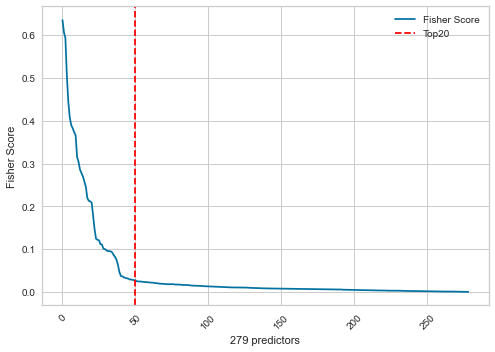

CPU times: total: 359 ms
Wall time: 374 ms


In [553]:
%%time
# Visualize the Fisher Score
plt.plot(fs_df['fisherscore'].values.squeeze())
plt.axvline(x=50, linestyle='dashed', color='red')
plt.xticks(rotation=45)
plt.xlabel(str(fs_df.shape[0]) + ' predictors')
plt.ylabel('Fisher Score')
plt.legend(['Fisher Score', 'Top20'])
plt.show()

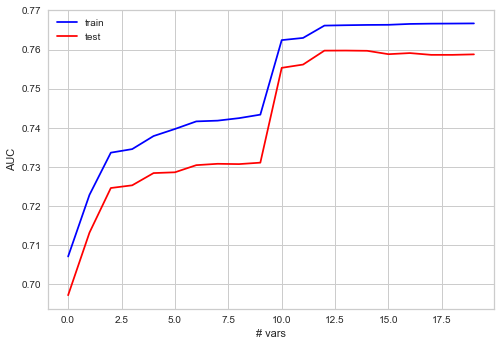

CPU times: total: 1.22 s
Wall time: 6.73 s


In [554]:
%%time
# Check how AUC change when add more variables: Top n vars
fs_scores = []
top_n_vars = 20
for i in range(1, top_n_vars+1):
    if i % 100 == 0: print('Added # top vars :', i)
    top_n_predictors = fs_df['predictor'][:i]
    clf = LogisticRegression()
    fs_scores.append(cross_validate(clf, train[top_n_predictors], train[target_var].values.squeeze(),
                                    scoring='roc_auc', cv=5, verbose=0, n_jobs=-1, return_train_score=True))

# How the AUC curve looks like when adding top vars
plt.plot([s['train_score'].mean() for s in fs_scores], color='blue')
plt.plot([s['test_score'].mean() for s in fs_scores], color='red')
plt.xlabel('# vars')
plt.ylabel('AUC')
plt.legend(['train', 'test'])
plt.show()

In [555]:
%%time
# Select the top variables based on Fisher Score
n_top_fs_vars = 20  # Top FS vars
top_fs_vars = fs_df['predictor'].values[:n_top_fs_vars]
print("Selected # vars :", len(top_fs_vars))
top_fs_vars

Selected # vars : 20
CPU times: total: 0 ns
Wall time: 0 ns


array(['PAY_0_woe', 'max_delay_3_binef_woe', 'max_delay_6_binef_woe',
       'PAY_2_woe', 'PAY_3_woe', 'max_delay_3', 'PAY_5_woe', 'PAY_4_woe',
       'max_delay_6', 'PAY_6_woe', 'avg_PAY_AMT6_binef_woe',
       'avg_PAY_AMT3_binef_woe', 'LIMIT_BAL_binef_woe',
       'PAY_AMT1_binef_woe', 'PAY_AMT2_binef_woe', 'LIMIT_BAL',
       'PAY_AMT3_binef_woe', 'PAY_AMT6_binef_woe', 'avg_PAY_AMT6',
       'PAY_AMT4_binef_woe'], dtype=object)

#### (b) Dimensional Reduction: PCA

In [556]:
%%time
# Build PCA and check the explained variance
# Note: If the num vars were scaled (but the dummy were not) PVE is no longer correct
pca = PCA(n_components=len(predictors))
pca.fit(train[predictors])
print("PVE =", pca.explained_variance_ratio_.sum())
# Transform train, test
train_pca = pca.transform(train[predictors])
test_pca = pca.transform(test[predictors])

PVE = 1.0
CPU times: total: 3.92 s
Wall time: 1.25 s


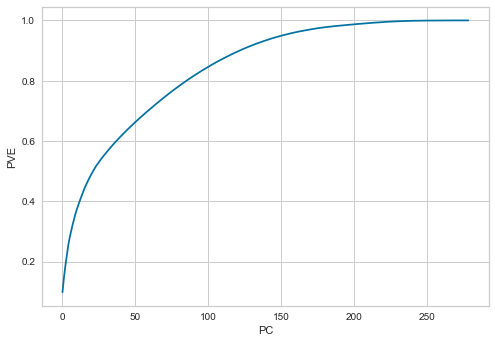

CPU times: total: 172 ms
Wall time: 180 ms


In [557]:
%%time
# Visualize the PVE of PCA
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('PC')
plt.ylabel('PVE')
plt.show()

In [558]:
%%time
# Reconstruct the loading vectors
loading_vecs = pca.components_.T * np.sqrt(pca.explained_variance_)
loading_vecs = pd.DataFrame(loading_vecs,
                            columns=['PC' + str(i) for i in list(range(1, pca.n_components_+1))],
                            index=predictors)
loading_vecs.iloc[:2, :2]

CPU times: total: 0 ns
Wall time: 2 ms


PC1       PC2
LIMIT_BAL -0.001812 -0.000110
AGE        0.000097  0.000315

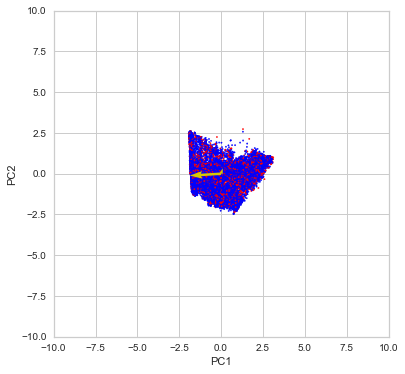

CPU times: total: 859 ms
Wall time: 868 ms


In [559]:
%%time
# Visualize the group of data
fig, axes = plt.subplots(1, 1, figsize=(6, 6))
colors = np.array(['blue'] * len(train[target_var]))
colors[train[target_var].squeeze() == 1] = 'red'
plt.scatter(x=train_pca[:, 0], y=train_pca[:, 1], color=colors, s=2)
plt.quiver([0, 0], [0, 0],
           loading_vecs.iloc[:2, :2]['PC1'].tolist(),
           loading_vecs.iloc[:2, :2]['PC2'].tolist(),
           color=['y','y'])
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

## 3. Modeling

<u>Note:</u>
- Mass feature engineering may lead to overfitting. Especially with the techniques that link information from the target variable to the predictors (including Fisher Score for variable selection).
- Therefore, the k-fold cross-validation in below is convenient to use, but is not a 100% correct method to estimate the performance of the models. Train, validation and test set should be processed separately to avoid information leakage.

<u>Reference:</u>  

- Lessmann, S., Baesens, B., Seow, H. V., & Thomas, L. C. (2015). Benchmarking state-of-the-art classification algorithms for credit scoring: An update of research. European Journal of Operational Research, 247(1), 124-136.File 

In [560]:
%%time
# List of parameter tuning using cross validation for all models
model_grid = {}

CPU times: total: 0 ns
Wall time: 0 ns


In [561]:
%%time
#########################################################
# MODIFY THE BELOW VALUE TO SET THE TARGET VARIABLE SET #
#########################################################

# Prepare the data according to the selected set of variables
if var_set == 'all':
    X = train[predictors]
    X_test = test[predictors]
    test_id = test[id_var]
elif var_set == 'fs':
    X = train[top_fs_vars]
    X_test = test[top_fs_vars]
    test_id = test[id_var]
elif var_set == 'pca':
    X = train_pca
    X_test = test_pca
    test_id = test[id_var]
y = train[target_var].values.squeeze()
print(X.shape)

# Update output file name
fname = '_' + data_prep + '_' + var_set + str(X.shape[1]) + '_' + exp_version
print(fname)

# Remove unused data
# del train, test, train_pca, test_pca

(20000, 20)
_full_fs20_v5.3
CPU times: total: 15.6 ms
Wall time: 9.99 ms


### 3.1. Modeling

In [562]:
from sklearn.model_selection import train_test_split
traincv, valid,ytraincv,yvalid = train_test_split(X,y, test_size=0.2, random_state=42)
traincv.columns

Index(['PAY_0_woe', 'max_delay_3_binef_woe', 'max_delay_6_binef_woe',
       'PAY_2_woe', 'PAY_3_woe', 'max_delay_3', 'PAY_5_woe', 'PAY_4_woe',
       'max_delay_6', 'PAY_6_woe', 'avg_PAY_AMT6_binef_woe',
       'avg_PAY_AMT3_binef_woe', 'LIMIT_BAL_binef_woe', 'PAY_AMT1_binef_woe',
       'PAY_AMT2_binef_woe', 'LIMIT_BAL', 'PAY_AMT3_binef_woe',
       'PAY_AMT6_binef_woe', 'avg_PAY_AMT6', 'PAY_AMT4_binef_woe'],
      dtype='object')

### Logistic regression

In [477]:
# Grid search cross validation

grid={"penalty":["l1","l2"],'solver' : ['liblinear']}# l1 lasso l2 ridge
#grid={"penalty":["l1","l2","elasticnet","none"],'solver' : ['saga']}# l1 lasso l2 ridge
logreg=LogisticRegression()
logreg_cv=GridSearchCV(logreg,grid,cv=5)
logreg_cv.fit(traincv, ytraincv)

print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'penalty': 'l2', 'solver': 'liblinear'}
accuracy : 0.8196875


In [478]:
from sklearn import metrics
#Performance
acc_lr = logreg_cv.score(valid, yvalid)
print("Accuracy: ",acc_lr)

lr_pred_proba = logreg_cv.predict_proba(valid)[:,1]

#calculate AUC of model
auc_lr = metrics.roc_auc_score(yvalid, lr_pred_proba)

#print AUC score
print("AUC: ",auc_lr)

Accuracy:  0.8035
AUC:  0.7548023526666292


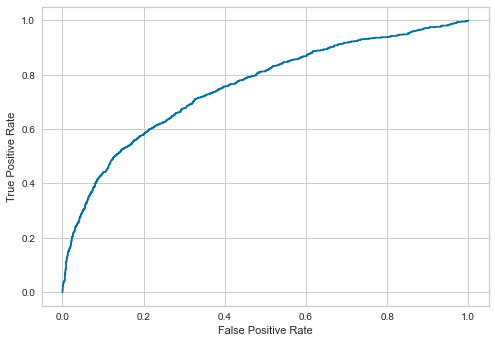

In [479]:
fpr, tpr, _ = metrics.roc_curve(yvalid, lr_pred_proba)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Random forest

In [357]:
rfc=RandomForestClassifier(random_state=42)
param_grid = { 
    'n_estimators': [100, 200, 500],
    'max_features': ['log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(traincv, ytraincv)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8], 'max_features': ['log2'],
                         'n_estimators': [100, 200, 500]})

In [358]:
CV_rfc.best_params_

{'criterion': 'gini',
 'max_depth': 6,
 'max_features': 'log2',
 'n_estimators': 200}

In [359]:
#Performance
acc_rf = CV_rfc.score(valid, yvalid)
print("Accuracy: ", acc_rf)

rf_pred_proba = CV_rfc.predict_proba(valid)[:,1]

#calculate AUC of model
auc_rf = metrics.roc_auc_score(yvalid, rf_pred_proba)

#print AUC score
print("AUC: ",auc_rf)

Accuracy:  0.80475
AUC:  0.7550585861816129


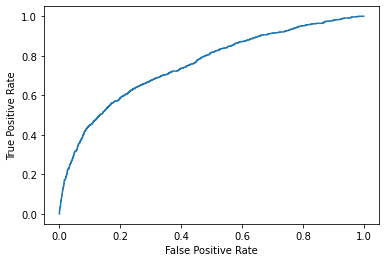

In [360]:
fpr, tpr, _ = metrics.roc_curve(yvalid, rf_pred_proba)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### KNN

In [570]:
#Model
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier()
param_grid = { 
    'n_neighbors': [3,5,7,10,11,13],
     'weights' : ['uniform', 'distance'] ,
    'leaf_size' : [10,30,50,100],
    'p' :[1,2]
}
CV_knn = GridSearchCV(estimator=knn, param_grid=param_grid, cv= 5)
CV_knn.fit(traincv, ytraincv)

print("tuned hpyerparameters :(best parameters) ",CV_knn.best_params_)
print("accuracy :",CV_knn.best_score_)

tuned hpyerparameters :(best parameters)  {'leaf_size': 10, 'n_neighbors': 13, 'p': 2, 'weights': 'uniform'}
accuracy : 0.8140000000000001


In [571]:
#Performance
acc_knn = CV_knn.score(valid, yvalid)
print("Accuracy: ",acc_knn)

knn_pred_proba = CV_knn.predict_proba(valid)[:,1]

#calculate AUC of model
auc_knn = metrics.roc_auc_score(yvalid, knn_pred_proba)

#print AUC score
print("AUC: ",auc_knn)

Accuracy:  0.80075
AUC:  0.7307245052154233


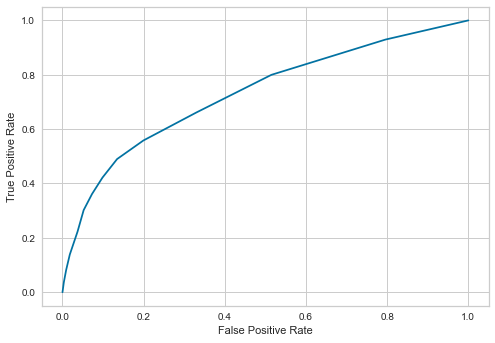

In [572]:
fpr, tpr, _ = metrics.roc_curve(yvalid, knn_pred_proba)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### XGBoosting

In [363]:
from xgboost import XGBClassifier
grid={"objective": ['binary:logistic'],'eta': [0.01,0.03,0.04,0.05,0.5],
      "max_depth":[1,2,3] , "subsample" : [0.7,0.8],
      "colsample_bylevel" :[0.7,0.8,0.9], "eval_metric":['auc'],
      "random_state":[42]}

XGB = XGBClassifier()
XGB_cv=GridSearchCV(XGB,grid,cv=5)

XGB_cv.fit(traincv, ytraincv)

print("tuned hpyerparameters :(best parameters) ",XGB_cv.best_params_)
print("accuracy :",XGB_cv.best_score_)

C:\tools\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\tools\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\tools\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in X

C:\tools\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\tools\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\tools\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in X

C:\tools\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\tools\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\tools\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in X

C:\tools\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\tools\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\tools\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in X

C:\tools\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\tools\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\tools\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in X

C:\tools\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\tools\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\tools\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in X

C:\tools\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\tools\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\tools\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in X

C:\tools\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\tools\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\tools\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in X

C:\tools\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\tools\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\tools\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in X

C:\tools\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\tools\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\tools\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in X

C:\tools\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\tools\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\tools\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in X

C:\tools\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\tools\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\tools\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in X

C:\tools\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\tools\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\tools\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in X

C:\tools\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\tools\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\tools\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in X

C:\tools\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\tools\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\tools\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in X

C:\tools\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\tools\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\tools\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in X

C:\tools\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\tools\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\tools\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in X

C:\tools\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\tools\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\tools\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in X

C:\tools\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\tools\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\tools\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in X

C:\tools\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\tools\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\tools\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in X

C:\tools\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\tools\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\tools\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in X

C:\tools\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\tools\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\tools\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in X

C:\tools\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\tools\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\tools\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in X

C:\tools\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\tools\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\tools\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in X

tuned hpyerparameters :(best parameters)  {'colsample_bylevel': 0.7, 'eta': 0.05, 'eval_metric': 'auc', 'max_depth': 3, 'objective': 'binary:logistic', 'random_state': 42, 'subsample': 0.7}
accuracy : 0.8223125


In [364]:
#Performance

acc_xgb = XGB_cv.score(valid, yvalid)
print("Accuracy: ",acc_xgb)
XGB_pred_proba = XGB_cv.predict_proba(valid)[:,1]

#calculate AUC of model
auc_XGB = metrics.roc_auc_score(yvalid, XGB_pred_proba)
#print AUC score
print("AUC: ",auc_XGB)

Accuracy:  0.806
AUC:  0.7629514067454057


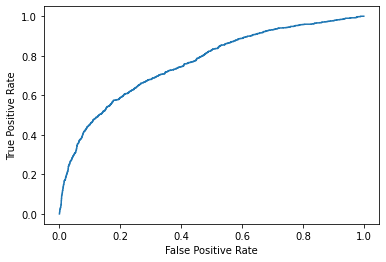

In [365]:
fpr, tpr, _ = metrics.roc_curve(yvalid, XGB_pred_proba)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### 3.2. Stacking & Voting ensemble

<u>Reference:</u>
- Ensemble methods. Link: https://scikit-learn.org/stable/modules/ensemble

### 1. Adaboost

In [573]:
from sklearn.model_selection import RepeatedStratifiedKFold
model = AdaBoostClassifier()
# define the grid of values to search
grid = dict()
grid['n_estimators'] = [10, 50, 100, 500]
grid['learning_rate'] = [0.0001, 0.001, 0.01, 0.1, 1.0]
# define the evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
# define the grid search procedure
gs_adaboost = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='roc_auc')
# execute the grid search
gs_adaboost = gs_adaboost.fit(traincv, ytraincv)
# summarize the best score and configuration
print("Best: %f using %s" % (gs_adaboost.best_score_, gs_adaboost.best_params_))
# summarize all scores that were evaluated
means = gs_adaboost.cv_results_['mean_test_score']
stds = gs_adaboost.cv_results_['std_test_score']
params = gs_adaboost.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.769668 using {'learning_rate': 0.1, 'n_estimators': 500}
0.641208 (0.013682) with: {'learning_rate': 0.0001, 'n_estimators': 10}
0.641208 (0.013682) with: {'learning_rate': 0.0001, 'n_estimators': 50}
0.641208 (0.013682) with: {'learning_rate': 0.0001, 'n_estimators': 100}
0.641208 (0.013682) with: {'learning_rate': 0.0001, 'n_estimators': 500}
0.641208 (0.013682) with: {'learning_rate': 0.001, 'n_estimators': 10}
0.641208 (0.013682) with: {'learning_rate': 0.001, 'n_estimators': 50}
0.643449 (0.016262) with: {'learning_rate': 0.001, 'n_estimators': 100}
0.716786 (0.018204) with: {'learning_rate': 0.001, 'n_estimators': 500}
0.641208 (0.013682) with: {'learning_rate': 0.01, 'n_estimators': 10}
0.716865 (0.018272) with: {'learning_rate': 0.01, 'n_estimators': 50}
0.725610 (0.017297) with: {'learning_rate': 0.01, 'n_estimators': 100}
0.764228 (0.018917) with: {'learning_rate': 0.01, 'n_estimators': 500}
0.724782 (0.017443) with: {'learning_rate': 0.1, 'n_estimators': 10}
0.764219

In [574]:
#Performance

acc_adab = gs_adaboost.score(valid, yvalid)
print("Accuracy: ",acc_xgb)
adab_pred_proba = gs_adaboost.predict_proba(valid)[:,1]

#calculate AUC of model
auc_adab = metrics.roc_auc_score(yvalid, adab_pred_proba)
#print AUC score
print("AUC: ",auc_adab)

Accuracy:  0.806
AUC:  0.7561650900112505


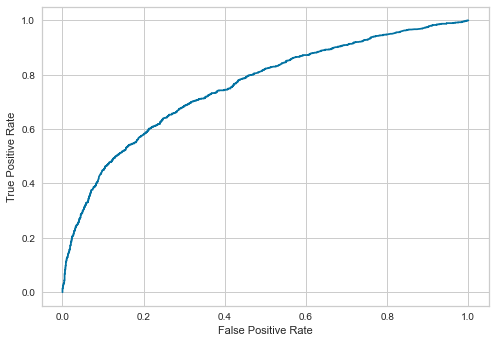

In [575]:
fpr, tpr, _ = metrics.roc_curve(yvalid, adab_pred_proba)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Voting ensemble

In [653]:
clf1 = LogisticRegression(penalty= 'l1', solver= 'liblinear')
clf2 = RandomForestClassifier(random_state=42, max_features='log2', n_estimators= 200, max_depth=6, criterion='gini')
clf3 = XGBClassifier(colsample_bylevel = 0.7, eta = 0.05, eval_metric = 'auc', max_depth = 3, objective= 'binary:logistic',
                     random_state= 42, subsample= 0.7)

eclf = VotingClassifier(
     estimators=[('lr', clf1), ('rf', clf2),('xgb',clf3)],
     voting='soft',
     weights=[1,1,1]
 )

params = {'lr__C': [1.0, 100.0], 'rf__n_estimators': [20, 200],'xgb__n_estimators': [20, 200,500]}
grid_vt = GridSearchCV(estimator=eclf, param_grid=params, cv=10)
grid_vt = grid_vt.fit(traincv, ytraincv)

print("tuned hpyerparameters :(best parameters) ",grid_vt.best_params_)
print("accuracy :",grid_vt.best_score_)

C:\tools\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\tools\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\tools\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in X

C:\tools\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\tools\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\tools\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in X

C:\tools\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\tools\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\tools\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in X

C:\tools\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\tools\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\tools\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in X

C:\tools\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\tools\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\tools\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in X

C:\tools\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\tools\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\tools\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in X

C:\tools\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\tools\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\tools\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in X

tuned hpyerparameters :(best parameters)  {'lr__C': 100.0, 'rf__n_estimators': 200, 'xgb__n_estimators': 20}
accuracy : 0.8218125000000001


In [654]:
#Performance
acc_vot = grid_vt.score(valid, yvalid)
print("Accuracy: ",acc_vot)

vot_pred_proba = grid_vt.predict_proba(valid)[:,1]

#calculate AUC of model
auc_vot = metrics.roc_auc_score(yvalid, vot_pred_proba)

#print AUC score
print("AUC: ",auc_vot)

Accuracy:  0.80325
AUC:  0.7561434821252364


### 3.3. Debugging

To detect overfitting, underfitting problem, we can analyze the following analyses:
- Each fold of the k-fold CV
- Learning curve

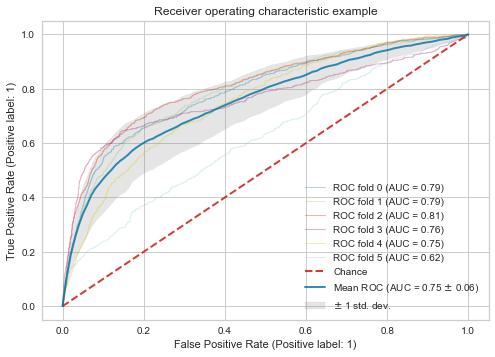

In [485]:
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import auc



cv = StratifiedKFold(n_splits=6)
classifier = LogisticRegression(penalty= 'l2', solver= 'liblinear')

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, (trainc, testc) in enumerate(cv.split(X, y)):
    classifier.fit(X.iloc[trainc,], y[trainc])
    viz = RocCurveDisplay.from_estimator(
        classifier,
        X.iloc[testc,],
        y[testc],
        name="ROC fold {}".format(i),
        alpha=0.3,
        lw=1,
        ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="Receiver operating characteristic example",
)
ax.legend(loc="lower right")
plt.show()

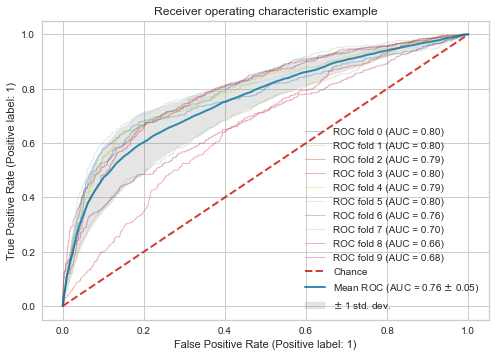

In [496]:
#Random forest
cv = StratifiedKFold(n_splits=10)
classifier = RandomForestClassifier(random_state=42, n_estimators= 100, max_depth=10, criterion='gini')

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, (trainc, testc) in enumerate(cv.split(X, y)):
    classifier.fit(X.iloc[trainc,], y[trainc])
    viz = RocCurveDisplay.from_estimator(
        classifier,
        X.iloc[testc,],
        y[testc],
        name="ROC fold {}".format(i),
        alpha=0.3,
        lw=1,
        ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="Receiver operating characteristic example",
)
ax.legend(loc="lower right")
plt.show()

C:\tools\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\tools\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\tools\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in X

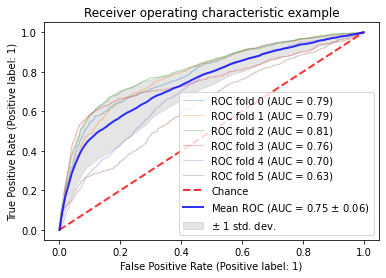

In [408]:
#Random forest
cv = StratifiedKFold(n_splits=6)
classifier = XGBClassifier(colsample_bylevel = 0.7, eta = 0.05, eval_metric = 'auc', max_depth = 3, objective= 'binary:logistic',
                     random_state= 42, subsample= 0.7)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, (trainc, testc) in enumerate(cv.split(X, y)):
    classifier.fit(X.iloc[trainc,], y[trainc])
    viz = RocCurveDisplay.from_estimator(
        classifier,
        X.iloc[testc,],
        y[testc],
        name="ROC fold {}".format(i),
        alpha=0.3,
        lw=1,
        ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="Receiver operating characteristic example",
)
ax.legend(loc="lower right")
plt.show()

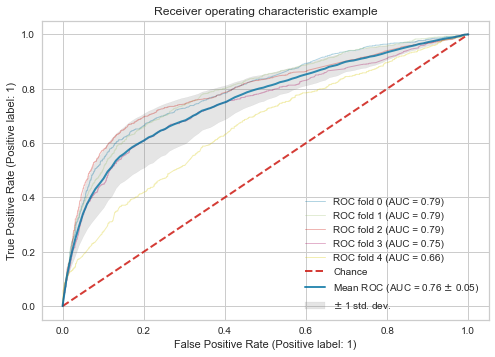

In [577]:
#Adaboost
cv = StratifiedKFold(n_splits=5)
classifier = AdaBoostClassifier(learning_rate= 0.1, n_estimators= 500)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, (trainc, testc) in enumerate(cv.split(X, y)):
    classifier.fit(X.iloc[trainc,], y[trainc])
    viz = RocCurveDisplay.from_estimator(
        classifier,
        X.iloc[testc,],
        y[testc],
        name="ROC fold {}".format(i),
        alpha=0.3,
        lw=1,
        ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="Receiver operating characteristic example",
)
ax.legend(loc="lower right")
plt.show()

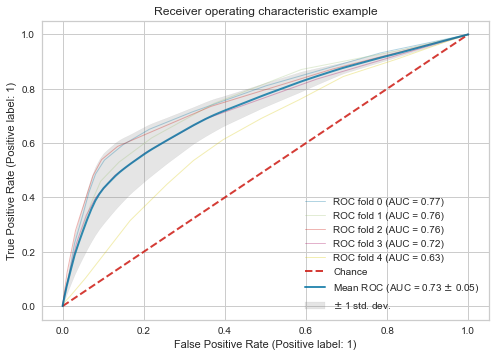

In [579]:
#KNN

cv = StratifiedKFold(n_splits=5)
classifier = KNeighborsClassifier(leaf_size= 10, n_neighbors = 13, p= 2, weights = 'uniform')

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, (trainc, testc) in enumerate(cv.split(X, y)):
    classifier.fit(X.iloc[trainc,], y[trainc])
    viz = RocCurveDisplay.from_estimator(
        classifier,
        X.iloc[testc,],
        y[testc],
        name="ROC fold {}".format(i),
        alpha=0.3,
        lw=1,
        ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="Receiver operating characteristic example",
)
ax.legend(loc="lower right")
plt.show()

C:\tools\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\tools\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\tools\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in X

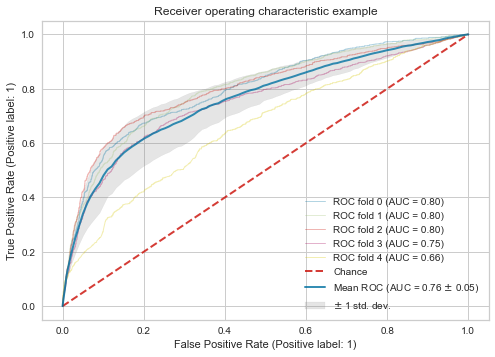

In [578]:
#Voting ensemble

cv = StratifiedKFold(n_splits=5)
classifier = VotingClassifier(
     estimators=[('lr', clf1), ('rf', clf2),('xgb',clf3)],
     voting='soft',
     weights=[1,1,1]
 )

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, (trainc, testc) in enumerate(cv.split(X, y)):
    classifier.fit(X.iloc[trainc,], y[trainc])
    viz = RocCurveDisplay.from_estimator(
        classifier,
        X.iloc[testc,],
        y[testc],
        name="ROC fold {}".format(i),
        alpha=0.3,
        lw=1,
        ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="Receiver operating characteristic example",
)
ax.legend(loc="lower right")
plt.show()

### Learning curve

#### a) Logistic regression

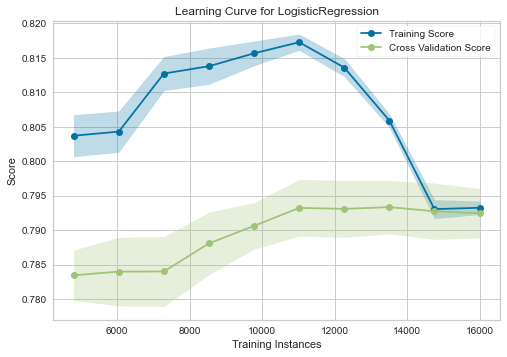

<AxesSubplot:title={'center':'Learning Curve for LogisticRegression'}, xlabel='Training Instances', ylabel='Score'>

In [481]:
from yellowbrick.model_selection import LearningCurve
# Create the learning curve visualizer
sizes = np.linspace(0.3, 1.0, 10)
lgreg = LogisticRegression(penalty= 'l2', solver= 'liblinear')

# Instantiate the classification model and visualizer
visualizer = LearningCurve(
    lgreg, cv=cv, scoring='f1_weighted', train_sizes=sizes, n_jobs=4
)

visualizer.fit(X, y)        # Fit the data to the visualizer
visualizer.show()        

#### b) Random forest

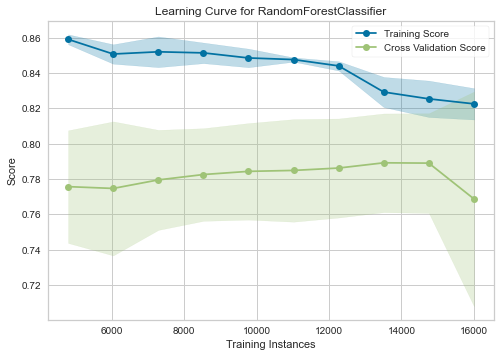

<AxesSubplot:title={'center':'Learning Curve for RandomForestClassifier'}, xlabel='Training Instances', ylabel='Score'>

In [618]:
# Create the learning curve visualizer
sizes = np.linspace(0.3, 1.0, 10)
rflc = RandomForestClassifier(random_state=42,  n_estimators= 9, max_depth=9, criterion='gini')

# Instantiate the classification model and visualizer
visualizer = LearningCurve(
    rflc, cv=cv, scoring='f1_weighted', train_sizes=sizes, n_jobs=4
)

visualizer.fit(X, y)        # Fit the data to the visualizer
visualizer.show()  

#### c) KNN

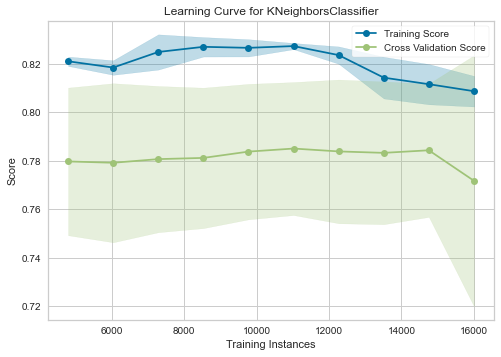

<AxesSubplot:title={'center':'Learning Curve for KNeighborsClassifier'}, xlabel='Training Instances', ylabel='Score'>

In [603]:
# Create the learning curve visualizer
sizes = np.linspace(0.3, 1.0, 10)
KNNcl =  KNeighborsClassifier(leaf_size= 10, n_neighbors = 13, p= 2, weights = 'uniform')
# Instantiate the classification model and visualizer
visualizer = LearningCurve(
    KNNcl, cv=cv, scoring='f1_weighted', train_sizes=sizes, n_jobs=4
)

visualizer.fit(X, y)        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure

#### d) XGBoosting

C:\tools\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\tools\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\tools\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in X

C:\tools\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\tools\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\tools\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in X

C:\tools\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\tools\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\tools\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in X

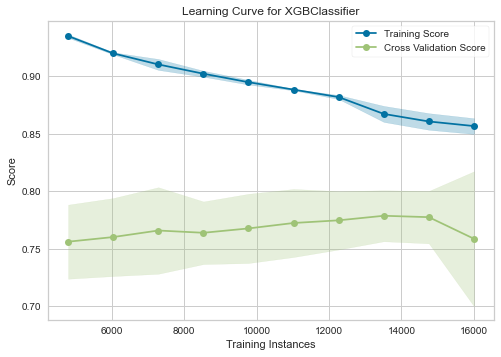

<AxesSubplot:title={'center':'Learning Curve for XGBClassifier'}, xlabel='Training Instances', ylabel='Score'>

In [625]:
# Create the learning curve visualizer
sizes = np.linspace(0.3, 1.0, 10)
xgbcl = XGBClassifier(colsample_bylevel = 0.8, eta = 0.4, eval_metric = 'auc', max_depth = 5, objective= 'binary:logistic',
                     random_state= 42, subsample= 0.7)
# Instantiate the classification model and visualizer
visualizer = LearningCurve(
    xgbcl, cv=cv, scoring='f1_weighted', train_sizes=sizes, n_jobs=4
)

visualizer.fit(X, y)        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure

#### e) Adaboosting

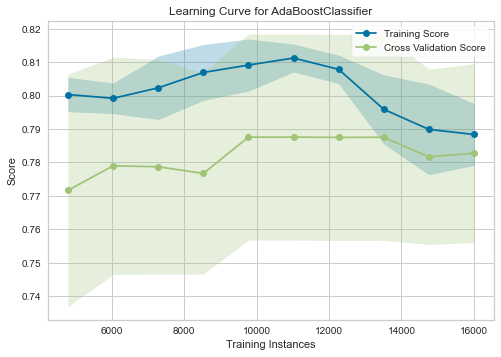

<AxesSubplot:title={'center':'Learning Curve for AdaBoostClassifier'}, xlabel='Training Instances', ylabel='Score'>

In [627]:
# Create the learning curve visualizer
sizes = np.linspace(0.3, 1.0, 10)
adabcl = AdaBoostClassifier(learning_rate= 0.09, n_estimators= 20)
# Instantiate the classification model and visualizer
visualizer = LearningCurve(
    adabcl, cv=cv, scoring='f1_weighted', train_sizes=sizes, n_jobs=4
)

visualizer.fit(X, y)        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure

#### f) Voting

C:\tools\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\tools\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\tools\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in X

C:\tools\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\tools\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\tools\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in X

C:\tools\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\tools\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\tools\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in X

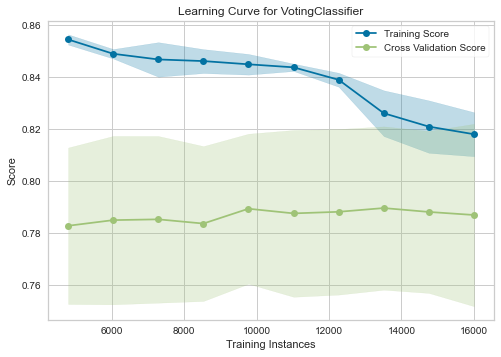

<AxesSubplot:title={'center':'Learning Curve for VotingClassifier'}, xlabel='Training Instances', ylabel='Score'>

In [629]:
# Create the learning curve visualizer
clf1 = LogisticRegression(penalty= 'l2', solver= 'liblinear')
clf2 = RandomForestClassifier(random_state=42,  n_estimators= 100, max_depth=10, criterion='gini')
clf3 =  KNeighborsClassifier(leaf_size= 10, n_neighbors = 13, p= 2, weights = 'uniform')
clf4 = XGBClassifier(colsample_bylevel = 0.8, eta = 0.4, eval_metric = 'auc', max_depth = 5, objective= 'binary:logistic',
                     random_state= 42, subsample= 0.7)
sizes = np.linspace(0.3, 1.0, 10)
voting_clf =VotingClassifier(
     estimators=[('lr', clf1), ('rf', clf2),('knn', clf3),('xgb',clf4)],
     voting='soft',
     weights=[2,1,1,1]
 )
# Instantiate the classification model and visualizer
visualizer = LearningCurve(
    voting_clf, cv=cv, scoring='f1_weighted', train_sizes=sizes, n_jobs=4
)

visualizer.fit(X, y)        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure

## Feature importance

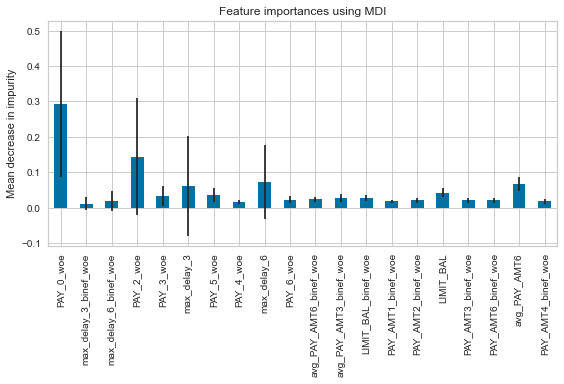

In [638]:
rflc.fit(X,y)
importances = rflc.feature_importances_
forest_importances = pd.Series(importances, index=X.columns)
std = np.std([tree.feature_importances_ for tree in rflc.estimators_], axis=0)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [642]:
lgreg=LogisticRegression(penalty= 'l2', solver= 'liblinear')
lgreg.fit(X,y)
lr_coef = lgreg.coef_

In [650]:
lr_coef =[ 2.00603694,  0.22018245,  0.67680006, -0.08005069,  0.34104304,
        -0.47139046,  0.56995624,  1.04733483, -0.54374459,  0.61198248,
         0.59422932,  0.05836116,  0.4533904 ,  0.07775377,  0.06602189,
         0.14877684,  0.12776986,  0.03673039, -0.23976661,  0.02144025]

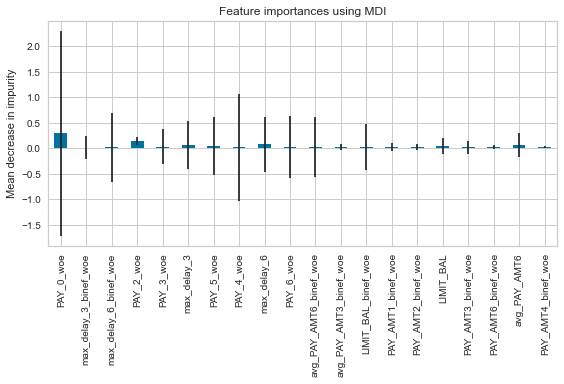

In [651]:
lr_importances = pd.Series(lr_coef, index=X.columns)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=lr_importances, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

## 4. Make prediction

Use the best model to make prediction on test set. Submit the result to Kaggle.

In [655]:
#Prediction in test set
test[target_var] = pd.Series(grid_vt.predict_proba(test[top_fs_vars])[:,1])
submission_vt_db = test[['cust_id','default.payment.next.month']]
submission_vt_db.head()

cust_id  default.payment.next.month
0    18847                    0.417220
1    14063                    0.209793
2    11914                    0.263435
3     7299                    0.728495
4    24759                    0.409838

In [656]:
submission_vt_db.to_csv("submission_vt_db.csv", index=False)

In [657]:
test.to_csv("test.csv", index=False)